# NetCDF Darwin sounding to DDA background file converter

Given a time period will output a .txt file with the height, U, and V from the TWP sounding from that time.

In [1]:
from netCDF4 import Dataset
from datetime import datetime, timedelta
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
# Load sounding file
sounding_file = '/home/rjackson/data/soundings/twpsondewnpnC3.b1.20020401.043300..20091230.172000.custom.cdf'

Sounding_netcdf = Dataset(sounding_file, mode='r')

# Convert timestamps to datetime format
Time = Sounding_netcdf.variables['time_offset'][:]
base_time = Sounding_netcdf.variables['base_time'][:]
alt = Sounding_netcdf.variables['alt'][:]
u = Sounding_netcdf.variables['u_wind'][:]
v = Sounding_netcdf.variables['v_wind'][:]

base_timestamp = timedelta(seconds=float(base_time)) + datetime(1970,1,1)


In [46]:
# Input time needed
year = 2006
month = 1
day = 20
hour = 0
minute = 50
second = 0

time_delta = datetime(year,month,day,hour,minute,second) - base_timestamp

seconds_in_file = time_delta.days*(24*60*60) + time_delta.seconds

def find_nearest(array, value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx



In [47]:
print(seconds_in_file)
nearest_index = find_nearest(Time[:], seconds_in_file)

# Go backwards in time until altitude stops decreasing
while(alt[nearest_index-1] < alt[nearest_index]):
    nearest_index = nearest_index - 1

# Go forwards in time until altitude_stops_increasing
furthest_index = nearest_index
while(alt[furthest_index+1] > alt[furthest_index]):
    furthest_index = furthest_index + 1  
    
u = u[int(nearest_index):int(furthest_index)]
v = v[int(nearest_index):int(furthest_index)]
alt = alt[int(nearest_index):int(furthest_index)]


120082620


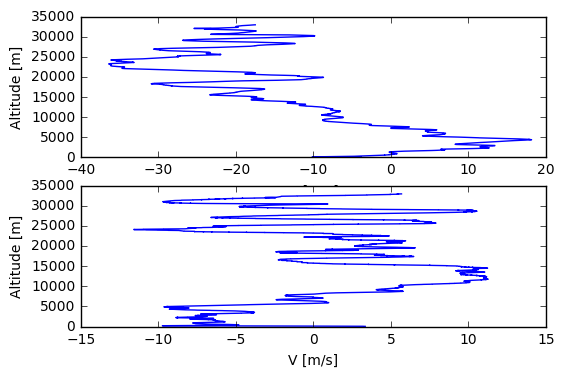

In [51]:
fig1 = plt.figure(figsize=(6,4))
plt.subplot(211)
plt.plot(u[~v.mask],alt[~v.mask])
plt.xlabel('U [m/s]')
plt.ylabel('Altitude [m]')

plt.subplot(212)
plt.plot(v[~v.mask],alt[~v.mask])
plt.xlabel('V [m/s]')
plt.ylabel('Altitude [m]')

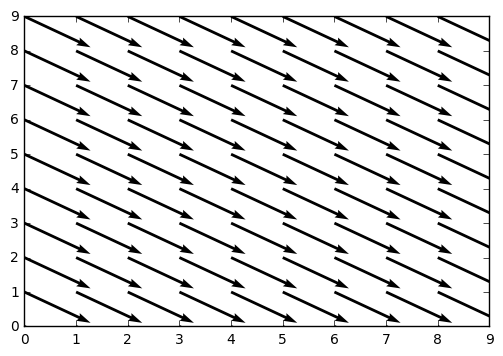

In [52]:
# Plot quiver field of u and w at given altitude
level = 4000.0

index = find_nearest(alt, level)
u_field, v_field = np.meshgrid(u[index]*np.ones((1,10)),v[index]*np.ones((1,10)))
fig1 = plt.figure()
plt.quiver(u_field,v_field, scale=100,)


In [53]:
file = open('sounding_file', 'w')

# Take 1000 evenly spaced levels from the sounding and place them into the file
u = u[~u.mask]
v = v[~v.mask]
alt = alt[~u.mask]
step = int(math.floor(len(u)/500))
for i in range(0, len(u), step):
    input_string = (str(alt[i]) + ' ' + str(u[i]) + ' ' + str(v[i]) + '\n')
    file.write(input_string)

file.close()

In [ ]:
u[-6]